Config settings:
N: 10
T_train_val: 10000
T_test: 1000
data_type: ar1
batch_size: 64
seq_length: 20
input_size: 10
output_size: 10
learning_rate: 0.001
num_epochs: 100
num_workers: 24
device: cuda
mix_precision: True
dg_config:
    mean_load: 50.0
    var_load: 10.0
    iid_var: 1.0
    theta: 0.9
ar_config:
    order: 5
lstm_config:
    hidden_size: 50
    num_layers: 4
gat_config:
    num_heads: 8
    num_layers: 3
--------------------------------------------------
load_iid.shape: (10, 11000)
load_iid.type: <class 'numpy.ndarray'>
load_ar1.shape: (10, 11000)
load_ar1.type: <class 'numpy.ndarray'>
data.shape: (10, 11000)
data.type: <class 'numpy.ndarray'>
train_val_data.shape: (10, 10000)
train_val_data.type: <class 'numpy.ndarray'>
test_data.shape: (10, 1000)
test_data.type: <class 'numpy.ndarray'>
train_sets.shape: torch.Size([9980, 20, 10])
train_sets.type: <class 'torch.Tensor'>
val_sets.shape: torch.Size([9980, 10])
val_sets.type: <class 'torch.Tensor'>
len(train_val_dataset): 99

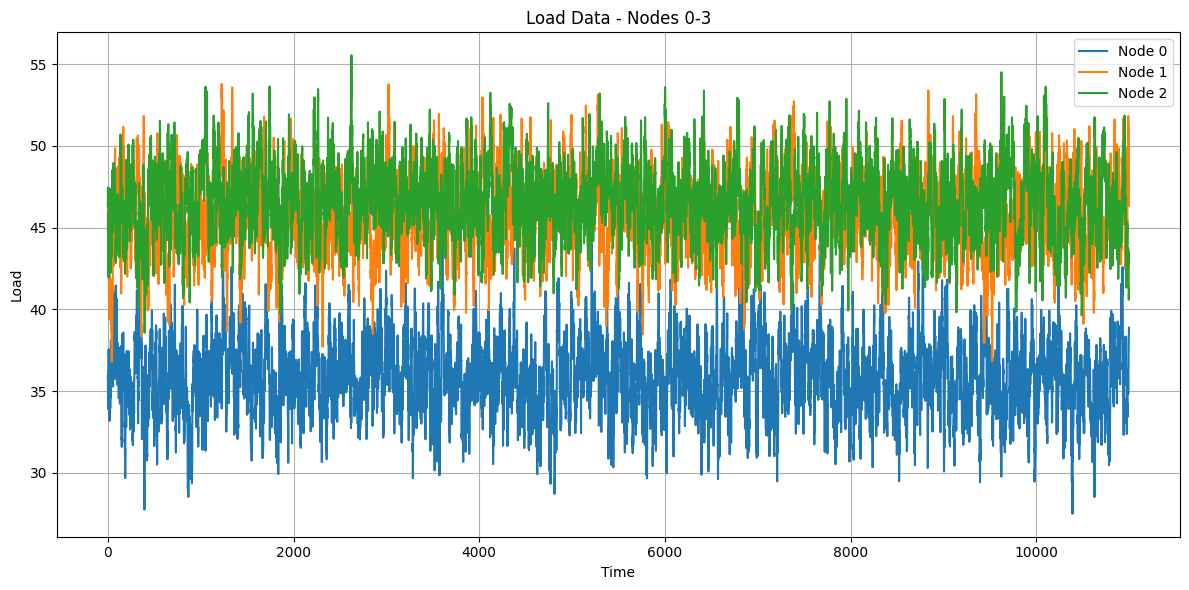

In [1]:
from Config_Data import Config, DataGenerateConfig, ARConfig, LSTMConfig, GATConfig, DataGenerate, DataManage
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

config = Config(
    N=10,
    T_train_val=10000,
    T_test=1000,
    data_type='ar1',

    batch_size=64,
    seq_length=20,
    input_size=10,
    output_size=10,
    learning_rate=0.001,
    num_epochs=100,
    num_workers=24,
    device= device,
    # device='cpu',
    mix_precision=True if device == 'cuda' else False,
    
    dg_config=DataGenerateConfig(mean_load=50.0, var_load=10.0, iid_var=1.0, theta=0.9),
    ar_config=ARConfig(order=5),
    lstm_config=LSTMConfig(hidden_size=50, num_layers=4),
    gat_config=GATConfig(num_heads=8, num_layers=3),
)
config.print_config_info()

RE_GENERATE_DATA = False

if RE_GENERATE_DATA:
    data_generate = DataGenerate(config)

data_manage = DataManage(config)
data = data_manage.data

data_manage.plot_range_data(data[:3, :], start=0, end=len(data[0]), title='Load Data')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import torch.optim.lr_scheduler as lr_scheduler


In [3]:
class ModelExpert:
    def __init__(self, config, data_manage, type='GAT'):
        self.config = config
        self.data_manage = data_manage
        
        self.type = type
        if self.type == 'LSTM':
            self.model = self.LSTMModel(self.config.input_size, self.config.lstm_config.hidden_size, self.config.output_size, self.config.lstm_config.num_layers).to(self.config.device)
        elif self.type == 'GAT':
            self.model = self.GATModel(self.config.input_size, self.config.output_size).to(self.config.device)
        else:
            raise ValueError("Invalid model type. Must be 'LSTM' or 'GAT'.")
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.config.learning_rate)

        # 初始化调度器
        self.scheduler = lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',  # 'min' 表示监控的指标需要最小化
            factor=0.1,  # 每次减少学习率的比例
            patience=2,  # 当监控的指标在 patience 个 epoch 内没有改善时减少学习率
            min_lr=1e-6  # 学习率的下限
        )

        self.predictions = None
        self.true_values = None

        # 用于记录损失和学习率的列表
        self.train_losses = []
        self.fine_tune_losses = []
        self.learning_rates = []
        self.fine_tune_learning_rates = []

        self.epochs_trained = 0  # 用于记录实际训练的 epoch 数

    class GATModel(nn.Module):
        def __init__(self, in_channels, out_channels, num_heads, num_layers):
            super().__init__()
            # 创建 GAT 模型
            # in_channels: 输入特征的维度， 通常为节点特征的维度, 为 10
            # out_channels: 输出特征的维度， 通常为预测的维度, 为 10
            # heads: 多头注意力的头数， 默认为 4
            # num_layers: GATConv 层的数量， 默认为 3
            
            
            # 定义 GAT 模型的层次列表
            self.convs = nn.ModuleList()
            
            # 第一层 GATConv，输入特征维度为 in_channels，输出特征维度为 16 * heads
            # heads 表示多头注意力的头数， concat=False 表示不进行拼接，输出的维度是各个头的平均值
            # 这种设置对较小的数据集效果更好，防止过拟合，同时减少计算量；对于大数据集，可以考虑设置为 True
            self.convs.append(GATConv(in_channels, 16, heads=num_heads, concat=False))
            
            # 中间层 GATConv，用于增加模型的深度，进一步提取特征，输出特征维度为 16 * heads
            # 这里的 num_layers 表示中间层的数量， -2 是因为第一层和最后一层已经定义了
            for _ in range(num_layers - 2):
                self.convs.append(GATConv(16 * num_heads, 16, heads=num_heads, concat=False))
            
            # 最后一层 GATConv，输出特征维度为 out_channels， 这里的 heads=1，表示单头注意力
            self.convs.append(GATConv(16 * num_heads, out_channels, heads=1, concat=False))
            
            # 定义 GRU 层，用于对节点特征进行时间维度上的建模, batch_first=True 表示输入的形状为 [batch_size, seq_length, feature_size]
            self.rnn = nn.GRU(out_channels, out_channels, batch_first=True)
            
            # 定义全连接层，用于最终的预测, 将GRU的输出特征维度转换为 out_channels，size为 10
            self.fc = nn.Linear(out_channels, out_channels)
    
        def forward(self, x, edge_index):
            # x: 节点特征，形状为 [N, in_channels]
            # edge_index: 边索引，形状为 [2, E]，其中 E 表示边的数量
            
            # 对每一层 GATConv 进行前向传播， 并使用 ReLU 激活函数
            for conv in self.convs[:-1]:
                # + x 表示残差连接，用于防止梯度消失
                x = F.relu(conv(x, edge_index)) + x  
            
            # 最后一层 GATConv 不需要进行 ReLU 激活函数，因为在 GATConv 中已经包含了激活函数
            # 这里不需要 + x，因为最后一层 GATConv 的输出特征维度已经是 out_channels
            # 此时输入的 x 的形状为 [batch, N, 16 * heads]
            # 经过self.convs[-1]后，输出的形状为 [batch, N, out_channels]
            x = self.convs[-1](x, edge_index)
            
            # 经过 GATConv 后，x 的形状为 [batch_size, N, out_channels]
            out, _ = self.rnn(x)
            
            # 取最后一个时间步的输出，进行全连接层映射，输出的形状为 [batch_size, N, out_channels]
            out = self.fc(out[:, -1, :])  


    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size, num_layers):
            super().__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.layer_norm = nn.LayerNorm(hidden_size)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h_0, c_0))
            out = self.layer_norm(out[:, -1, :])
            out = self.fc(out)
            return out

    # 定义早停机制类
    class EarlyStopping:
        def __init__(self, patience=5, min_delta=1e-4):
            # patience: 当验证集损失连续 patience 次没有下降时，停止训练
            # min_delta: 最小的损失下降值，小于该值则不认为损失下降
            
            self.patience = patience
            self.min_delta = min_delta
            self.counter = 0
            self.best_loss = None
            self.early_stop = False
    
        def __call__(self, train_loss):
            if self.best_loss is None:
                self.best_loss = train_loss
            elif train_loss < self.best_loss - self.min_delta:
                self.best_loss = train_loss
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True     

    def train(self):
        scaler = torch.amp.GradScaler(device=self.config.device) if self.config.mix_precision else None
        # TODO: early_stopping = self.EarlyStopping(patience=self.config.patience)  # 初始化早停机制，patience可以在config中配置
        early_stopping = self.EarlyStopping()

        print(f'device: {torch.cuda.get_device_name() if self.config.device == "cuda" else "CPU"}')

        self.model.train()
        for epoch in tqdm(range(self.config.num_epochs), desc="Training"):
            train_cumulative_loss = 0.0  # 训练集累积损失
            
            for train, val in self.data_manage.dataloader:
                # 确保数据在 GPU 上，且异步加载
                train, val = train.to(self.config.device, non_blocking=True).float(), val.to(self.config.device, non_blocking=True).float()

                self.optimizer.zero_grad()  # 梯度清零

                if self.config.mix_precision:  # 混合精度训练
                    with torch.amp.autocast(device_type=self.config.device):
                        if self.type == 'LSTM':
                            pred = self.model(train)
                            loss = self.criterion(pred, val)
                        elif self.type == 'GAT':
                            pred = self.model(train, self.data_manage.edge_index)
                            loss = self.criterion(pred, val)

                    scaler.scale(loss).backward()
                    scaler.step(self.optimizer)
                    scaler.update()

                else:
                    if self.type == 'LSTM':
                        pred = self.model(train)  # 前向传播
                        loss = self.criterion(pred, val)  # 计算损失
                    elif self.type == 'GAT':
                        pred = self.model(train, self.data_manage.edge_index)
                        loss = self.criterion(pred, val)
                        
                    loss.backward()  # 反向传播
                    self.optimizer.step()  # 更新参数

                train_cumulative_loss += loss.item()
                self.train_losses.append(loss.item())  # 记录单次损失

            # 在每个epoch结束时，计算验证集的平均损失
            train_avg_loss = train_cumulative_loss / len(self.data_manage.dataloader)

            # 早停机制
            early_stopping(train_avg_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered. Stopping training. Epoch: {epoch + 1}")
                break

            # 调度器更新
            self.scheduler.step(train_avg_loss)
            
            # print(f'Epoch [{epoch + 1}/{self.config.num_epochs}], Loss: {train_loss:.4f}')
            current_lr = self.scheduler.optimizer.param_groups[0]['lr']
            self.learning_rates.append(current_lr)  # 记录学习率
            # print(f'Current Learning Rate: {current_lr:.6f}')

            if (epoch + 1) % 10 == 0:  # 每10轮输出一次损失, 以及释放GPU缓存
                print(f'Epoch [{epoch + 1}/{self.config.num_epochs}], Ave_Loss: {train_avg_loss:.4f}')
                print(f'Current Learning Rate: {current_lr:.6f}')

                if torch.cuda.is_available():  # 释放GPU缓存
                    torch.cuda.empty_cache()

        self.epochs_trained = epoch + 1  # 记录训练的总 epoch 数
        print(f"Training finished after {self.epochs_trained} epochs.")
        print(f"Final training loss: {train_avg_loss:.4f}")
        print(f'average loss: {train_avg_loss / self.epochs_trained:.4f}')

    def predict_and_fine_tune(self):
        tune_cumulative_loss = 0.0  # 微调累积损失
        predictions = torch.zeros((self.config.T_test, self.config.output_size), device=self.config.device)
        true_values = torch.zeros((self.config.T_test, self.config.output_size), device=self.config.device)

        # 选择训练集的最后一部分数据作为输入
        input_data = self.data_manage.train_val_data[:, -self.config.seq_length:].T.unsqueeze(0).to(self.config.device)  #  shape: [1, seq_length, input_size], [1, 20, 10]

        #  测试数据集
        test_data = self.data_manage.test_data.to(self.config.device)  # 将测试数据转移到 GPU, shape: [T_test, output_size], [1000, 10]

        for i in tqdm(range(self.config.T_test), desc="Predicting and Fine-tuning"):
            self.model.train()  # 模型保持在训练模式，以便进行微调
            if self.type == 'LSTM':
                pred = self.model(input_data)  # 预测
            elif self.type == 'GAT':
                pred = self.model(input_data, self.data_manage.edge_index)  # 预测
            real_value = test_data[:, i].to(self.config.device)  # 真实值

            # predictions.append(pred.squeeze(0).detach().cpu().numpy())
            # # 形状[1, 10]转换为 [10], 从计算图中分离(以分离开梯度，不然没法使用.numpy())，从GPU转移到CPU, 最后转为 NumPy 数组
            # true_values.append(real_value.detach().cpu().numpy())

            predictions[i] = pred.squeeze(0)  # 将预测值保存到 predictions, shape: [T_test, output_size], [1000, 10]
            true_values[i] = real_value  # 将真实值保存到 true_values, shape: [T_test, output_size], [1000, 10]

            loss = self.criterion(pred.squeeze(0), real_value)  # 计算损失
            tune_cumulative_loss += loss.item()  # 累加损失
            self.fine_tune_losses.append(loss.item())  # 记录单次损失
            
            if (i + 1) % 100 == 0:  # 每100步输出一次损失
                print(f'Step {i + 1}/{self.config.T_test}, Loss: {loss.item():.4f}')

            # 使用真实值进行微调
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # 在每个epoch结束时，计算验证集的平均损失
            tune_avg_loss = tune_cumulative_loss / (i + 1)

            # 调度器更新（可选，基于微调期间的损失）
            self.scheduler.step(tune_avg_loss)
            current_lr = self.scheduler.get_last_lr()[0]
            self.fine_tune_learning_rates.append(current_lr)

        # 更新输入序列
            input_data = torch.cat((input_data[:, 1:, :], real_value.unsqueeze(0).unsqueeze(0)), dim=1)
            
        # 计算平均损失
        print(f'Average Fine-tuning Loss over {self.config.T_test} steps: {tune_avg_loss:.4f}')

        # 将预测值和真实值转换为 NumPy 数组
        # self.predictions = np.array(predictions)
        # self.true_values = np.array(true_values)
        self.predictions = predictions.detach().cpu().numpy()
        self.true_values = true_values.detach().cpu().numpy()

    def plot_training_curves(self):
        plt.figure(figsize=(12, 8))
    
        # 绘制训练损失
        plt.subplot(3, 1, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(range(len(self.train_losses), len(self.train_losses) + len(self.fine_tune_losses)), self.fine_tune_losses, label='Fine-tuning Loss', color='orange')
        plt.axvline(x=len(self.train_losses), color='r', linestyle='--', label='Training/Fine-tuning Boundary')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Loss Over Time')
        plt.legend()
    
        # 绘制累积损失
        cumulative_train_loss = [sum(self.train_losses[:i+1]) for i in range(len(self.train_losses))]
        cumulative_fine_tune_loss = [sum(self.fine_tune_losses[:i+1]) for i in range(len(self.fine_tune_losses))]
        plt.subplot(3, 1, 2)
        plt.plot(cumulative_train_loss, label='Cumulative Training Loss')
        plt.plot(range(len(self.train_losses), len(self.train_losses) + len(cumulative_fine_tune_loss)), cumulative_fine_tune_loss, label='Cumulative Fine-tuning Loss', color='orange')
        plt.axvline(x=len(self.train_losses), color='r', linestyle='--', label='Training/Fine-tuning Boundary')
        plt.xlabel('Steps')
        plt.ylabel('Cumulative Loss')
        plt.title('Cumulative Loss Over Time')
        plt.legend()
    
        # 绘制学习率变化
        plt.subplot(3, 1, 3)
        plt.plot(self.train_learning_rates, label='Training Learning Rate')
        plt.plot(range(len(self.train_learning_rates), len(self.train_learning_rates) + len(self.fine_tune_learning_rates)), self.fine_tune_learning_rates, label='Fine-tuning Learning Rate', color='orange')
        plt.axvline(x=len(self.train_learning_rates), color='r', linestyle='--', label='Training/Fine-tuning Boundary')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Over Time')
        plt.legend()
    
        plt.tight_layout()
        plt.show()
        
    def save_training_data(self, file_path):
        training_data = {
            'train_losses': self.train_losses,
            'fine_tune_losses': self.fine_tune_losses,
            'train_learning_rates': self.train_learning_rates,
            'fine_tune_learning_rates': self.fine_tune_learning_rates,
            'epochs_trained': self.epochs_trained
        }
        with open(file_path, 'w') as f:
            json.dump(training_data, f)

    def get_prediction_at_time(self, t):
        if self.predictions is None or self.true_values is None:
            raise ValueError("You must run predict_and_fine_tune() before accessing predictions.")
        return self.predictions[t], self.true_values[t]

    def plot_results(self, predictions, true_values):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions[:, 0], label='Predicted')
        plt.plot(true_values[:, 0], label='True')
        plt.xlabel('Time Steps')
        plt.ylabel('Load Value')
        plt.title('Predicted vs True Load Values for Node 1')
        plt.legend()
        plt.show()

In [4]:
gat_expert = ModelExpert(config, data_manage, type='LSTM')

In [ ]:
%%time
gat_expert.train()

device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  10%|█         | 10/100 [01:25<14:17,  9.52s/it]

Epoch [10/100], Ave_Loss: 5.2461
Current Learning Rate: 0.001000


Training:  20%|██        | 20/100 [03:04<13:07,  9.85s/it]

Epoch [20/100], Ave_Loss: 4.4493
Current Learning Rate: 0.001000


Training:  30%|███       | 30/100 [04:44<11:36,  9.95s/it]

Epoch [30/100], Ave_Loss: 3.1477
Current Learning Rate: 0.001000


Training:  33%|███▎      | 33/100 [05:14<11:12, 10.03s/it]

In [ ]:
%%time
gat_expert.predict_and_fine_tune()  # 预测并微调

In [ ]:
gat_expert.plot_training_curves()  # 绘制训练曲线

In [ ]:
t = 50
predicted, true_value = gat_expert.get_prediction_at_time(t)
print(f"Predicted values for t={t}: {predicted}")
print(f"True values for t={t}: {true_value}")
# 绘制预测与真实值对比图
gat_expert.plot_results(gat_expert.predictions, gat_expert.true_values)


In [ ]:
# class DataManage:
#     def __init__(self, config: Config):
#         self.config = config  # 配置
#         self.load_ar1 = pd.read_csv('load_ar1_data.csv').values  # 加载ar1数据, shape: (N, T), 10*11000
# 
#         self.train_val_data = self.load_ar1[:, :self.config.T_train_val]  # 训练集和验证集数据, shape: (N, T_train_val), 10*10000
#         self.test_data = self.load_ar1[:, self.config.T_train_val:]  # 测试集数据, shape: (N, T_test), 10*1000
# 
#         # 划分训练集和验证集 (前80%为训练集，后20%为验证集)
#         train_size = int(0.8 * self.train_val_data.shape[1])
#         val_size = self.train_val_data.shape[1] - train_size
# 
#         self.train_data = self.train_val_data[:, :train_size]
#         self.val_data = self.train_val_data[:, train_size:]
# 
#         # 创建数据集
#         self.train_sets, self.val_sets = self._create_sequences(self.train_data), self._create_sequences(self.val_data)
# 
#         # 创建DataLoader
#         self.train_dataset = TensorDataset(*self.train_sets)
#         self.val_dataset = TensorDataset(*self.val_sets)
# 
#         self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.config.batch_size, shuffle=True, num_workers=self.config.num_workers)
#         self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.config.batch_size, shuffle=False, num_workers=self.config.num_workers)
# 
#         self.print_data_manage_info()
#         self.print_dataloader_info()
# 
#     def _create_sequences(self, data):
#         train_sets = []
#         val_sets = []
#         for i in range(data.shape[1] - self.config.seq_length):
#             train = data[:, i: i + self.config.seq_length].T  # 提取每个时间步的序列
#             val = data[:, i + self.config.seq_length]  # 提取目标值
#             train_sets.append(train)
#             val_sets.append(val)
#         return torch.tensor(np.array(train_sets)), torch.tensor(np.array(val_sets))
